In [47]:
################i tested rbm from the guy in github, this code has implemented the exact pper from hinton.

import glob
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
from tqdm import tqdm
import h5py
I=0
def _parse_function(example_proto):
    features = {"X": tf.FixedLenFeature((257), tf.float32),
              "Y": tf.FixedLenFeature((257), tf.float32)}
    parsed_features = tf.parse_single_example(example_proto, features)
    return parsed_features["X"], parsed_features["Y"]

def rbm_layer(n_visible, n_hidden, num_epochs, num_cases, lr, ws, bs, layer_n, len_data, directories):
    
    Data_path = directories[0]
    tfrecord_folder_parent = directories[1]
    tfrecord_folder = directories[2]
    
    tfrecord_path_x = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_folder))
    sorted_names_x = natsorted(os.listdir(tfrecord_path_x))
    trainfilenames_x = []
    for i in sorted_names_x:
        trainfilenames_x.append(os.path.normpath(os.path.join(tfrecord_path_x,i)))
#     filenames_x = tf.placeholder(tf.string, shape=[None])
    dataset_x = tf.data.TFRecordDataset(trainfilenames_x)
    dataset_x = dataset_x.map(_parse_function)  # Parse the record into tensors.
#     dataset_x = dataset_x.repeat()  # Repeat the input indefinitely.
    dataset_x = dataset_x.batch(batch_size)
#     iterator_x = dataset_x.make_initializable_iterator()

#     x  = tf.placeholder(tf.float32, [None, n_visible], name="x") #The placeholder variable that holds our data
    W  = tf.Variable(tf.random_normal([n_visible, n_hidden], 0.01), name="W") #The weight matrix that stores the edge weights
#     bh = tf.Variable(tf.zeros([1, n_hidden],  tf.float32, name="bh")) #The bias vector for the hidden layer
#     bv = tf.Variable(tf.zeros([1, n_visible],  tf.float32, name="bv")) #The bias vector for the visible layer
    bh = tf.ones([1, n_hidden],  tf.float32, name="bh") #The bias vector for the hidden layer
    bv = tf.ones([1, n_visible],  tf.float32, name="bv") #The bias vector for the visible layer
    
    W_adder  = tf.zeros((n_visible,n_hidden),dtype=tf.dtypes.float32)
    bh_adder = tf.zeros((1,n_hidden),dtype=tf.dtypes.float32)
    bv_adder = tf.zeros((1,n_visible),dtype=tf.dtypes.float32)
    
    CDpos  = tf.zeros((n_visible,n_hidden),dtype=tf.dtypes.float32)
    CDneg = tf.zeros((n_visible,n_hidden),dtype=tf.dtypes.float32)
    
    data_points = 100000
    sig = 0.2
#     weight_decay = 0.01
#     initialmomentum  = 0.5
#     finalmomentum    = 0.9
    
    weight_decay = 0.01
    initialmomentum  = 0
    finalmomentum    = 0   
    def sample(probs):
        #Takes in a vector of probabilities, and returns a random vector of 0s and 1s sampled from the input vector
        return tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1))


    def gibbs_sample(k,data):
        #Runs a k-step gibbs chain to sample from the probability distribution of the RBM defined by W, bh, bv
        def gibbs_step(count, k, data):
            #Runs a single gibbs step. The visible values are initialized to xk
            hk = sample(tf.sigmoid(tf.matmul(data, W) + bh+ sig*tf.random.normal((len(x[0]),len(W[0])),mean=0.0,stddev=1))) #Propagate the visible values to sample the hidden values
#             xk   = tf.sigmoid(tf.matmul(hk, tf.transpose(W)) + bv)
            data = sample(tf.truncated_normal((1,n_visible),tf.matmul(hk, tf.transpose(W)) + bv,1))
            return count+1, k, data
#         print('2')
        ct = tf.constant(0) #counter
        #Run gibbs steps for k iterations
        [_, _, x_sample]=control_flow_ops.while_loop(lambda count, num_iter, *args: count < num_iter,
                                             gibbs_step, [ct, tf.constant(k), data], back_prop = False)
#         print('3')
        #This is not strictly necessary in this implementation, but if you want to adapt this code to use one of TensorFlow's
        #optimizers, you need this in order to stop tensorflow from propagating gradients back through the gibbs step
        x_sample = tf.stop_gradient(x_sample) 
#         print('4')
        return x_sample

    ### Training Update Code
    # Now we implement the contrastive divergence algorithm. First, we get the samples of x and h from the probability distribution
    #The sample of x
#     print('1')
#     x_sample = gibbs_sample(5) 
#     #The sample of the hidden nodes, starting from the visible state of x
#     h = sample(tf.sigmoid(tf.matmul(x, W) + bh)) 
#     #The sample of the hidden nodes, starting from the visible state of x_sample
#     h_sample = sample(tf.sigmoid(tf.matmul(x_sample, W) + bh)) 

#     #Next, we update the values of W, bh, and bv, based on the difference between the samples that we drew and the original values
# #     size_bt = tf.cast(tf.shape(x)[0], tf.float32)
#     W_adder  = tf.multiply(lr, tf.subtract(tf.matmul(tf.transpose(x), h), tf.matmul(tf.transpose(x_sample), h_sample)))
#     bv_adder = tf.multiply(lr, tf.reduce_sum(tf.subtract(x, x_sample), 0, True))
#     bh_adder = tf.multiply(lr, tf.reduce_sum(tf.subtract(h, h_sample), 0, True))
#     #When we do sess.run(updt), TensorFlow will run all 3 update steps
#     updt = [W.assign_add(W_adder), bv.assign_add(bv_adder), bh.assign_add(bh_adder)]



    ### Run the graph!
    # Now it's time to start a session and run the graph! 

    incount=0
    for epoch in tqdm(range(num_epochs)):
        #Train the RBM on batch_size examples at a time
#             for X_batch in da(batch_size, layer_n, ws, bs, len_data, name, data_name):
        for x in dataset_x:
            incount+=1
            if incount%1000==0:
                print(incount)
#             if layer_n>1:
#                 for j in range(layer_n):
#                     x_0 = np.matmul(x[0],ws[j])+bs[j]
#             else:
#                 x_0 = x[0]
            x_sample = gibbs_sample(2,x[0]) 
            #The sample of the hidden nodes, starting from the visible state of x
            h = tf.sigmoid(tf.matmul(x[0], W) + bh+ sig*tf.random.normal((len(x[0]),len(W[0])),mean=0.0,stddev=1))
            #The sample of the hidden nodes, starting from the visible state of x_sample
            h_sample = sample(tf.sigmoid(tf.matmul(x_sample, W) + bh))
            if epoch>5:
                m=finalmomentum
            else:
                m=initialmomentum
            #Next, we update the values of W, bh, and bv, based on the difference between the samples that we drew and the original values
        #     size_bt = tf.cast(tf.shape(x)[0], tf.float32)
            CDpos = CDpos + tf.matmul(tf.transpose(x[0]), h)
            CDneg = CDneg + tf.matmul(tf.transpose(x_sample), h_sample)/data_points
        CDpos = CDpos/data_points  
        CDneg = CDneg/data_points  
        W_adder  = (m * W_adder) + tf.multiply(lr, tf.subtract(tf.matmul(tf.transpose(x[0]), h), tf.matmul(tf.transpose(x_sample), h_sample)))- W*weight_decay
#         bv_adder = (m * bv_adder) + tf.multiply(lr, tf.reduce_sum(tf.subtract(x[0], x_sample), 0, True))
#         bh_adder = (m * bh_adder) + tf.multiply(lr, tf.reduce_sum(tf.subtract(h, h_sample), 0, True))
            #When we do sess.run(updt), TensorFlow will run all 3 update steps
#         updt = [W.assign_add(W_adder), bv.assign_add(bv_adder), bh.assign_add(bh_adder)]
        updt = [W.assign_add(W_adder), bv, bh]
    return updt




In [48]:
# import libraries.
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
import datetime
tf.enable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from pystoi.stoi import stoi
import h5py
######################
#import libraries.
import matplotlib.pyplot as plt
from tabulate import tabulate
import time
import os
import librosa
from librosa.core import stft, istft
####import sounddevice as sd
import time
print('imported')
# #######################
Data_path = 'D:/studies/university/thesis/speech_separation_codes/du16/donesomestuff'
# Data_path = os.getcwd()
tfrecord_folder_parent = 'tfrecord_files'
tfrecord_folder = 'mixed_10h_norm2'
tfrecord_val_folder = 'validation_10h'
# ckpt_folder = '3'
dirs = [Data_path, tfrecord_folder_parent, tfrecord_folder]
 
# len_data = (684108, 257)
# len_data = (100000, 257)
len_data = (2197278, 257)
val_len = (97278,257)
w=1
#######################
#define reconstruct function to reconstruct sound from framed signal.
def reconstruct(wave,angle):
    recon = np.sqrt(np.power(10, wave))
    recon1 = recon*np.cos(angle)+recon*np.sin(angle)*1j
    recon = librosa.core.istft((recon1.T), hop_length=200, win_length=500, window='hann')
    return recon
#######################
I=0
global batch_size
batch_size = 128
# epochs_num=50
global datalen
datalen=len_data[0]

h = [512,512]
seed = 7
rate1 = 0.1
rate2 = 0.2
# from tensorflow.keras.layers import Activation
# # from keras.layers import Activation
# np.random.seed(seed)
# model = Sequential()
# act1 = layers.LeakyReLU(alpha=0.1)
# model.add(layers.Dropout(rate1, noise_shape=None, seed=None))
# # ,kernel_regularizer=regularizers.l2(0.001)
# model.add(Dense(h[0], input_dim = w*len_data[1]))
# model.add(BatchNormalization())
# model.add(act1)
# # model.add(Activation('sigmoid'))
# act2=layers.LeakyReLU(alpha=0.1)
# model.add(layers.Dropout(rate2, noise_shape=None, seed=None))
# model.add(Dense(h[1]))
# model.add(act2)
# # act3=layers.LeakyReLU(alpha=0.1)
# # # model.add(layers.Dropout(rate, noise_shape=None, seed=None))
# # model.add(Dense(h[2]))
# # model.add(act3)
# act=layers.LeakyReLU(alpha=0.01)
# model.add(Dense(len_data[1]))
#############################################
import os
from natsort import natsorted

# def _parse_function(example_proto):
#     print('1')
#     features = {"X": tf.FixedLenFeature((3*257), tf.float32),
#               "Y": tf.FixedLenFeature((257), tf.float32)}
#     parsed_features = tf.parse_single_example(example_proto, features)
#     print("i was here")
#     print('2')
#     return parsed_features["X"], parsed_features["Y"]

# tfrecord_path = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_folder))
# sorted_names = natsorted(os.listdir(tfrecord_path))
# trainfilenames = []
# for i in sorted_names:
#     trainfilenames.append(os.path.normpath(os.path.join(tfrecord_path,i)))
# filenames = tf.placeholder(tf.string, shape=[None])
# dataset = tf.data.TFRecordDataset(filenames)
# dataset = dataset.map(_parse_function)  # Parse the record into tensors.
# dataset = dataset.repeat()  # Repeat the input indefinitely.
# dataset = dataset.batch(batch_size)
# iterator = dataset.make_initializable_iterator()

# # orig_path = os.getcwd()
# tfrecord_path_x = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_folder))
# sorted_names_x = natsorted(os.listdir(tfrecord_path_x))
# trainfilenames_x = []
# for i in sorted_names_x:
#     trainfilenames_x.append(os.path.normpath(os.path.join(tfrecord_path,i)))
# filenames_x = tf.placeholder(tf.string, shape=[None])
# dataset_x = tf.data.TFRecordDataset(filenames_x)
# dataset_x = dataset_x.map(_parse_function)  # Parse the record into tensors.
# dataset_x = dataset_x.repeat()  # Repeat the input indefinitely.
# dataset_x = dataset_x.batch(batch_size)
# iterator_x = dataset_x.make_initializable_iterator()

########################
visible = w*len_data[1]
hidden = h[0]
visible1 = h[0]
hidden1 = h[1]
visible2 = h[1]
hidden2 = len_data[1]

layer1 = rbm_layer(visible, hidden, 20, batch_size, 0.1, [np.eye(visible)], [np.zeros((1,visible))], 1, len_data[0],dirs)
# layer2 = rbm_layer(visible1, hidden1, 50, batch_size, 0.01, [np.eye(visible),layer1[0]], [np.zeros((1,visible)),layer1[2]], 2, len_data[0], dirs)
# layer3 = rbm_layer(visible2, hidden2, 50, batch_size, 0.01, [np.eye(visible),layer1[0],layer2[0]], [np.zeros((1,visible)),layer1[2],layer2[2]], 3, len_data[0], dirs)

###############################

# tfrecord_path_val = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_val_folder))
# sorted_names_val = natsorted(os.listdir(tfrecord_path_val))
# trainfilenames_val = []
# for i in sorted_names_val:
#     trainfilenames_val.append(os.path.normpath(os.path.join(tfrecord_path_val,i)))
# filenames_val = tf.placeholder(tf.string, shape=[None])
# dataset_val = tf.data.TFRecordDataset(filenames_val)
# dataset_val = dataset_val.map(_parse_function)  # Parse the record into tensors.
# dataset_val = dataset_val.repeat()  # Repeat the input indefinitely.
# dataset_val = dataset_val.batch(128)
# iterator_val = dataset_val.make_initializable_iterator()

# epochs_num = 50
# steps = len_data[0] // batch_size
# val_steps = val_len[0] // batch_size
# # You can feed the initializer with the appropriate filenames for the current
# # phase of execution, e.g. training vs. validation.
# # next_elem = iterator_val.get_next()
# # Initialize `iterator` with training data.

# if not os.path.exists(os.path.join(Data_path,"checkpoints",ckpt_folder)):
#     os.makedirs(os.path.join(Data_path,"checkpoints",ckpt_folder))

# print(datetime.datetime.now())
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     sess.run(iterator.initializer, feed_dict={filenames: trainfilenames})
#     sess.run(iterator_val.initializer, feed_dict={filenames_val: trainfilenames_val})
#     print("initialized")
#     checkpoint_path = os.path.normpath(os.path.join(Data_path,"checkpoints",ckpt_folder,"weights.{epoch:02d}.hdf5"))
#     checkpoint_dir = os.path.dirname(checkpoint_path)

#     cp_callback = tf.keras.callbacks.ModelCheckpoint(
#         checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)
#         # Save weights, every 5-epochs.
# #         period=1)
#     early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
#     opt = tf.keras.optimizers.Adamax()
# #     opt = tf.train.AdamOptimizer()
# #     opt = tf.keras.optimizers.SGD()
#     model.compile(loss='mean_squared_error', optimizer=opt)
#     history = model.fit( iterator, steps_per_epoch=steps,epochs=epochs_num, callbacks = [cp_callback,early_stop], verbose=1,validation_data=iterator_val,validation_steps=val_steps)
# #     model.save(os.path.normpath(os.path.join(Data_path, 'models', "model_3h_dataset.h5")))
# #     tf.keras.models.save_model(model, os.path.normpath(os.path.join(Data_path, 'models', "model_3h_dataset.h5")))
# #     model.save_weights(os.path.normpath(os.path.join(Data_path, 'models', "model_3h_dataset.h5")))
#     model_json = model.to_json()
#     with open(os.path.normpath(os.path.join(Data_path, 'models', "model_3.json")), "w") as json_file:
#         json_file.write(model_json)
#     # # serialize weights to HDF5
#     model.save_weights(os.path.normpath(os.path.join(Data_path, 'models', "model_3.h5")))
#     print("Saved model to disk")
    
# print(datetime.datetime.now())
# %matplotlib inline
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train'], loc='upper left')
# plt.show()
# plt.savefig(os.path.normpath(os.path.join(Data_path,'images',ckpt_folder+'.png')))
# # model_json = model.to_json()
# # with open("model_10h_dataset.json", "w") as json_file:
# #     json_file.write(model_json)
# # model.save_weights("model_10h_dataset.h5")
# # print("Saved model to disk")


imported






  0%|                                                                                           | 0/20 [00:00<?, ?it/s]



  5%|████▏                                                                              | 1/20 [00:14<04:40, 14.77s/it]

1000






 10%|████████▎                                                                          | 2/20 [00:28<04:19, 14.43s/it]

2000






 15%|████████████▍                                                                      | 3/20 [00:41<03:59, 14.11s/it]

3000






 20%|████████████████▌                                                                  | 4/20 [00:55<03:41, 13.86s/it]



 25%|████████████████████▊                                                              | 5/20 [01:08<03:27, 13.85s/it]

4000






 30%|████████████████████████▉                                                          | 6/20 [01:22<03:12, 13.76s/it]

5000






 35%|█████████████████████████████                                                      | 7/20 [01:36<02:58, 13.71s/it]

6000






 40%|█████████████████████████████████▏                                                 | 8/20 [01:49<02:43, 13.65s/it]

7000






 45%|█████████████████████████████████████▎                                             | 9/20 [02:03<02:30, 13.66s/it]



 50%|█████████████████████████████████████████                                         | 10/20 [02:18<02:20, 14.02s/it]

8000






 55%|█████████████████████████████████████████████                                     | 11/20 [02:32<02:06, 14.02s/it]

9000






 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:46<01:52, 14.00s/it]

10000






 65%|█████████████████████████████████████████████████████▎                            | 13/20 [03:00<01:38, 14.04s/it]



 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [03:15<01:26, 14.35s/it]

11000






 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [03:29<01:11, 14.24s/it]

12000






 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:43<00:56, 14.23s/it]

13000






 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [03:56<00:42, 14.01s/it]

14000






 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [04:11<00:28, 14.30s/it]



 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [04:25<00:14, 14.16s/it]

15000






100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:39<00:00, 14.00s/it]

In [49]:
layer1[0].numpy()

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [18]:
write_path = 'D:/studies/university/thesis/speech_separation_codes/du16/donesomestuff/10hdata'
mixed_folder = os.path.normpath(os.path.join(write_path,'mixed_log_10h_norm2'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr = h5f['mixed_log_10h_norm2'][0:126]
h5f.close()
mixed_folder = os.path.normpath(os.path.join(write_path,'mixed_phase_10h_nozeroinsert'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr_phase = h5f['mixed_phase_10h_nozeroinsert'][0:126]
h5f.close()
mixed_folder = os.path.normpath(os.path.join(write_path,'mixed_log_10h_nozeroinsert'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr_raw = h5f['mixed_log_10h_nozeroinsert'][0:126]
h5f.close()

In [37]:
hidden1 = np.matmul(ftr,layer1[0].numpy())+layer1[2]
# hidden2 = np.matmul(hidden1,layer2[0])+layer2[2]
# hidden3 = np.matmul(hidden2,layer3[0])+layer3[2]
hidden1_b = np.matmul(hidden1,layer1[0].numpy().T)+layer1[1]
# hidden2_b = np.matmul(hidden3_b,layer2[0].T)+layer2[1]
# hidden1_b = np.matmul(hidden2_b,layer1[0].T)+layer1[1]

In [38]:
hidden1_b

<tf.Tensor: id=13622700, shape=(126, 257), dtype=float32, numpy=
array([[ 8.1481102e+01, -3.1999548e+01, -4.2016037e+01, ...,
        -8.6838641e+02, -2.9303830e-02,  2.3330821e+02],
       [ 7.5040947e+01, -2.1919357e+02, -1.7176888e+02, ...,
        -8.3385431e+02, -7.4401268e+01, -3.4883771e+02],
       [ 3.6552094e+02,  6.9319237e+01, -1.2640253e+02, ...,
        -8.8427722e+02, -8.7484961e+00,  2.6013117e+01],
       ...,
       [-1.7064370e+03, -2.3507266e+03, -1.3966254e+03, ...,
        -1.7608463e+03, -2.4625664e+02, -3.0107550e+02],
       [-1.7064370e+03, -2.3507266e+03, -1.3966254e+03, ...,
        -1.7608463e+03, -2.4625664e+02, -3.0107550e+02],
       [-1.7064370e+03, -2.3507266e+03, -1.3966254e+03, ...,
        -1.7608463e+03, -2.4625664e+02, -3.0107550e+02]], dtype=float32)>

In [39]:
ftr

array([[ 0.28766647,  0.11526573, -0.7069241 , ..., -0.55612373,
        -0.5525803 , -0.50696164],
       [ 0.12223668,  0.26682785, -0.4372746 , ..., -0.99636066,
        -1.0043348 , -1.5150769 ],
       [ 0.8128672 ,  0.6103882 , -0.9415356 , ..., -1.1297925 ,
        -0.9657317 , -0.59864193],
       ...,
       [-4.825073  , -5.533287  , -4.9773455 , ..., -2.2312639 ,
        -2.2086217 , -1.930099  ],
       [-4.825073  , -5.533287  , -4.9773455 , ..., -2.2312639 ,
        -2.2086217 , -1.930099  ],
       [-4.825073  , -5.533287  , -4.9773455 , ..., -2.2312639 ,
        -2.2086217 , -1.930099  ]], dtype=float32)

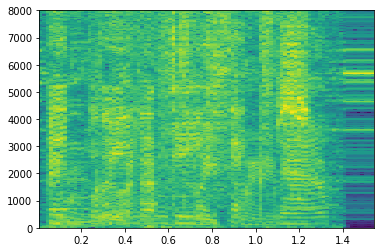

In [44]:
mean = np.loadtxt(os.path.normpath(os.path.join(write_path,'mean_mixed_log.txt')))
std = np.loadtxt(os.path.normpath(os.path.join(write_path,'std_mixed_log.txt')))
hidden1_b_unnorm = (hidden1_b*std)+mean
recon = reconstruct(hidden1_b_unnorm/500, ftr_phase)
import sounddevice as sd
sd.play(recon,16000)

Pxx, freqs, bins, im = plt.specgram(recon, NFFT=512, Fs=16000, noverlap=256)
plt.show()

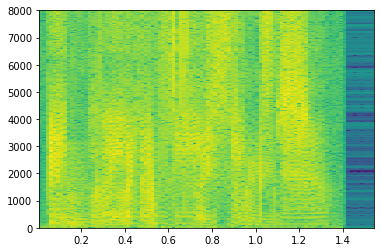

In [94]:
recon = reconstruct(hidden1_b, ftr_phase)
import sounddevice as sd
sd.play(recon,16000)
Pxx, freqs, bins, im = plt.specgram(recon, NFFT=512, Fs=16000, noverlap=256)
plt.show()

In [27]:
a=tf.constant([1,2,3])
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    label_numpy = a.eval()

In [97]:
import h5py 
import tensorflow as tf
hh = h5py.File('ftr_refrmd_10h.hdf5', 'r')
d=hh['ftr_refrmd_10h'][0]
len_data=d.shape
hh.close()
len_data

(771,)

In [24]:
file.close()

In [92]:
dataset

<PrefetchDataset shapes: ((?, 257), (?,)), types: (tf.float32, tf.float32)>